<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/PuNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 56007952.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1921934.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14188626.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9185404.42it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Train Epoch: 1 [0/60000 (0%)]	Loss: 193.322174
Train Epoch: 1 [6400/60000 (11%)]	Loss: 156.622147
Train Epoch: 1 [12800/60000 (21%)]	Loss: 128.860535
Train Epoch: 1 [19200/60000 (32%)]	Loss: 80.333931
Train Epoch: 1 [25600/60000 (43%)]	Loss: 70.307762
Train Epoch: 1 [32000/60000 (53%)]	Loss: 66.385307
Train Epoch: 1 [38400/60000 (64%)]	Loss: 65.393265
Train Epoch: 1 [44800/60000 (75%)]	Loss: 41.365257
Train Epoch: 1 [51200/60000 (85%)]	Loss: 33.658192
Train Epoch: 1 [57600/60000 (96%)]	Loss: 49.794018

Test set: Average loss: 0.6349, Accuracy: 4123/10000 (41%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 41.793713
Train Epoch: 2 [6400/60000 (11%)]	Loss: 32.156754
Train Epoch: 2 [12800/60000 (21%)]	Loss: 26.329891
Train Epoch: 2 [19200/60000 (32%)]	Loss: 29.492214
Train Epoch: 2 [25600/60000 (43%)]	Loss: 28.899853
Train Epoch: 2 [32000/60000 (53%)]	Loss: 31.208221
Train Epoch: 2 [38400/60000 (64%)]	Loss: 21.180784
Train Epoch: 2 [44800/60000 (75%)]	Loss: 21.822556
Train Epoch: 2 [51200/60000 (8

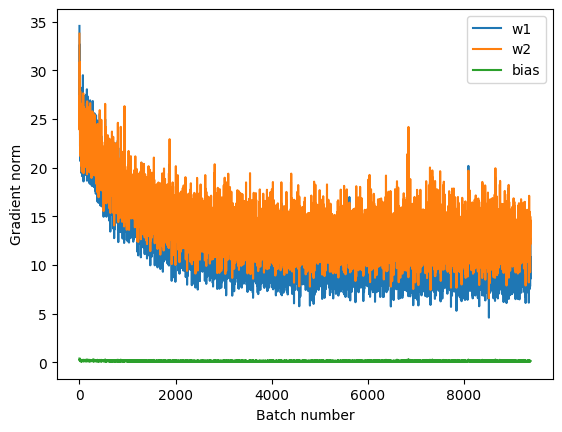

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class ProductUnitNN(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(ProductUnitNN, self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim

        # Initialize weights
        self.w1 = nn.Parameter(torch.randn(input_dim, hid_dim), requires_grad=True)
        self.w2 = nn.Parameter(torch.randn(hid_dim, output_dim), requires_grad=True)
        self.bias = nn.Parameter(torch.ones(output_dim) * -1, requires_grad=True)

    def forward(self, x):
        # Adjust net_sig computation
        net_sig = torch.zeros((x.size(0), self.hid_dim), device=x.device)
        for i in range(self.input_dim):
            condition = x[:, i].unsqueeze(1) != 0
            values_to_add = torch.sum(self.w1 * torch.log(torch.abs(x.unsqueeze(2) - 1)), dim=1)
            # Expand condition to match net_sig's shape for broadcasting
            condition = condition.expand_as(net_sig)  # Becomes (batch_size, hid_dim)
            net_sig = torch.where(condition, values_to_add, net_sig)
        z = net_sig @ self.w2 + self.bias
        return z

# Training settings
batch_size = 64
learning_rate = 0.001
epochs = 10

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss function, optimizer
input_dim = 784  # 28x28 images flattened
hid_dim = 100    # Example hidden dimension
output_dim = 10  # 10 classes for MNIST

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ProductUnitNN(input_dim, hid_dim, output_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Store gradient norms
grad_norms = {name: [] for name, param in model.named_parameters()}

# Training the model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(-1, input_dim).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Calculate and store gradient norms
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norms[name].append(param.grad.norm().item())

        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Testing the model
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(-1, input_dim).to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

# Plot gradient norms
for name, norms in grad_norms.items():
    plt.plot(norms, label=name)
plt.xlabel('Batch number')
plt.ylabel('Gradient norm')
plt.legend()
plt.show()
